## **Deepcut มาคัดข่าว**

Jupyter notebook สำหรับโพสต์จาก tupleblog [Deepcut มาคัดข่าว](https://tupleblog.github.io/deepcut-classify-news/)

เริ่มต้นจากเราต้องโคลน repository ของข่าว `wannaphongcom/thaigov-corpus`

In [2]:
!git clone https://github.com/wannaphongcom/thaigov-corpus thaigov-corpus 

Cloning into 'thaigov-corpus'...
remote: Counting objects: 17954, done.
remote: Compressing objects: 100% (14104/14104), done.
remote: Total 17954 (delta 9185), reused 12599 (delta 3844), pack-reused 0
Receiving objects: 100% (17954/17954), 19.06 MiB | 1.86 MiB/s, done.
Resolving deltas: 100% (9185/9185), done.


In [23]:
import numpy as np
import pandas as pd
import deepcut
from glob import glob

โหลดข่าวขึ้นมาและนับจำนวนข่าวแต่ละประเภท

In [4]:
paths = glob('thaigov-corpus/*/*.txt')

def get_news_type(path):
    """get news type from path to file"""
    return path.split('/')[-1].split('_')[0]

news_type_df = pd.DataFrame([get_news_type(path) for path in paths],
                            columns=['news_type']).groupby('news_type').size().reset_index()

In [5]:
# จำนวนข่าวแต่ละประเภท
news_type_df.sort_values(0, ascending=False)

,news_type,0
10,ด้านเศรษฐกิจ,2659
1,ข่าวทำเนียบรัฐบาล,2092
9,ด้านสังคม,1338
7,ด้านความมั่นคง,817
6,ด้านการศึกษาฯ,802
5,ด้านกฎหมายฯ,557
14,รายการวิทยุไทยคู่ฟ้า,171
12,ประเด็นเด่น,138
8,ด้านวัฒนธรรมท่องเที่ยวฯ,98
16,สรุปข่าวการประชุม ครม.,79


In [6]:
def read_text_file(path):
    """อ่านไฟล์จาก path ได้ได้รับ"""
    f = open(path, 'r')
    lines = f.readlines()
    return [l for l in lines if not l.startswith('ที่มา')]

topics = ['ด้านการศึกษาฯ', 'ด้านเศรษฐกิจ', 'ด้านความมั่นคง',
          'ข่าวทำเนียบรัฐบาล', 'ด้านสังคม', 'ด้านกฎหมายฯ'] # เลือกข่าวที่สนใจมา 6 ประเภทก่อน
df = pd.DataFrame(paths, columns=['file_path'])
df['text'] = df.file_path.map(read_text_file)
df['news_type'] = df.file_path.map(get_news_type)
df = df[df.news_type.map(lambda x: x in topics)] # เลือกเฉพาะข่าวที่สนใจ

In [7]:
from itertools import chain
def tokenize_text_list(ls):
    """Tokenize list of text"""
    return list(chain.from_iterable([deepcut.tokenize(l) for l in ls]))
tokenized_texts = df.text.map(tokenize_text_list) # รันนานหน่อยนะบรรทัดนี้

## แปลงลิสต์ของข่าวเป็น Bag-of-words

`tokenized_text` นี่จะเก็บเป็นลิสต์ของคำที่ตัดมาโดยใช้ `deepcut` เราสามารถเปลี่ยนให้เป็น bag of words เมทริกซ์ได้ไม่ยากมาก โค้ดเพื่อเปลี่ยนลิสต์ของคำเป็น bag of words สามารถทำได้ตามด้านล่างเลย

In [35]:
import scipy.sparse as sp

def text_to_bow(tokenized_text, vocabulary_):
    """ฟังก์ชันเพื่อแปลงลิสต์ของ tokenized text เป็น sparse matrix"""
    n_doc = len(tokenized_text)
    values, row_indices, col_indices = [], [], []
    for r, tokens in enumerate(tokenized_text):
        feature = {}
        for token in tokens:
            word_index = vocabulary_.get(token)
            if word_index is not None:
                if word_index not in feature.keys():
                    feature[word_index] = 1
                else:
                    feature[word_index] += 1
        for c, v in feature.items():
            values.append(v)
            row_indices.append(r)
            col_indices.append(c)

    # document-term matrix in sparse CSR format
    X = sp.csr_matrix((values, (row_indices, col_indices)),
                      shape=(n_doc, len(vocabulary_)))
    return X

vocabulary_ = {v: k for k, v in enumerate(set(chain.from_iterable(tokenized_texts)))}
X = text_to_bow(tokenized_texts, vocabulary_)

## **นำ Deepcut มาคัดข่าว**

In [16]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split

transformer = TfidfTransformer()
svd_model = TruncatedSVD(n_components=100, algorithm='arpack', n_iter=100)
X_tfidf = transformer.fit_transform(X)
X_svd = svd_model.fit_transform(X_tfidf)
y = pd.get_dummies(df.news_type).as_matrix() # แปลงจากประเภทข่าวให้เป็นฟอร์แมต 0, 1 แทน
X_train, X_test, y_train, y_test = train_test_split(X_svd, y, stratify=y)

/Users/titipata/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [17]:
pd.get_dummies(df.news_type).head() # ตัวอย่างของ pd.get_dummies()

,ข่าวทำเนียบรัฐบาล,ด้านกฎหมายฯ,ด้านการศึกษาฯ,ด้านความมั่นคง,ด้านสังคม,ด้านเศรษฐกิจ
0,0,0,1,0,0,0
1,0,0,1,0,0,0
2,0,0,0,0,0,1
3,0,0,0,0,0,1
4,0,0,0,0,0,1


In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

logist_model = LogisticRegression()
cv_scores = []
for c in range(y.shape[1]):
    cv_scores.append(cross_val_score(logist_model, X_svd, y[:, c], cv=10, scoring='accuracy').mean())
news_type = pd.get_dummies(df.news_type).columns # ประเภทข่าวที่สนใจ
list(zip(news_type, cv_scores))

[('ข่าวทำเนียบรัฐบาล', 0.9396227477900364),
 ('ด้านกฎหมายฯ', 0.9870547822708584),
 ('ด้านการศึกษาฯ', 0.9674521365359503),
 ('ด้านความมั่นคง', 0.9496678096700233),
 ('ด้านสังคม', 0.9443473736519051),
 ('ด้านเศรษฐกิจ', 0.9321212435287405)]

## **Confusion matrix**

In [32]:
from sklearn.metrics import confusion_matrix
import itertools 
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [25]:
logist_models = []
for c in range(y.shape[1]):
    logist_model = LogisticRegression()
    logist_model.fit(X_train, y_train[:, c])
    logist_models.append(logist_model)

In [29]:
y_pred = np.argmax(np.vstack([model.predict_proba(X_svd)[:, 1] for model in logist_models]).T, axis=1)
y_pred = np.array([news_type[yi] for yi in y_pred])
y_true = df.news_type.as_matrix()
C = confusion_matrix(y_true, y_pred) # confusion matrix

Confusion matrix, without normalization
[[1835    1   36   14   28  178]
 [  14  513    0    0    1   29]
 [  16    0  677    2   38   69]
 [  53    1   12  611   26  114]
 [  36    0    4   10 1134  154]
 [  30    1    8    3   67 2550]]


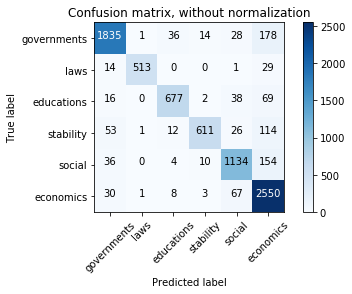

In [33]:
plot_confusion_matrix(C, classes=['governments', 'laws', 'educations', 'stability', 'social', 'economics'],
                      title='Confusion matrix, without normalization')

## **เทรนโมเดลและลองใส่ข่าวเข้าไปเอง**

ยกตัวอย่างถ้าเราจะใส่ข่าวใหม่เข้าไป เพื่อดูว่าข่าวนี้จะเป็นข่าวประเภทไหน (ในที่นี้เราจะลองใส่ข่าวเศรษฐกิจเข้าไปฮะ)

In [38]:
text =  'วันศุกร์ที่ 4 สิงหาคม 2560\n', 'ASEAN-India Expo and Forum การเชื่อมโยงอาเซียน-อินเดียครั้งสำคัญ สู่การเติบโตและเสถียรภาพของเศรษฐกิจโลก ฯพณฯ นายกรัฐมนตรี พลเอกประยุทธ์ จันทร์โอชา เป็นประธานในพิธีเปิด “ASEAN-India Expo and Forum” วาระทางเศรษฐกิจแห่งปี ซึ่งมีรัฐบาลไทยโดยกระทรวงพาณิชย์เป็นเจ้าภาพ จับมือกับหน่วยงานพันธมิตร และอีก 9 ประเทศสมาชิกอาเซียนรวมทั้งประเทศอินเดีย จัดเวทีพบปะครั้งใหญ่ระหว่างผู้แทนระดับสูงภาครัฐและภาคเอกชนจากทั้งสองฝ่าย ...'
tokenized_text = deepcut.tokenize(text)
x = text_to_bow([tokenized_text], vocabulary_)
x_tfidf = transformer.transform(x)
x_svd = svd_model.transform(x_tfidf)
pred = [model.predict_proba(x_svd.reshape(-1, 1).T).ravel()[1] for model in logist_models]
list(zip(news_type, pred))

/Users/titipata/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


[('ข่าวทำเนียบรัฐบาล', 0.06477508500756307),
 ('ด้านกฎหมายฯ', 0.3533984885848497),
 ('ด้านการศึกษาฯ', 0.04546127620116576),
 ('ด้านความมั่นคง', 0.1622837599196038),
 ('ด้านสังคม', 0.034806093935178944),
 ('ด้านเศรษฐกิจ', 0.47833163414165886)]